In [25]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, MaxPool2D
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split

In [26]:
def extract_plate(img):
  plate_img = cv2.imread(img)
  plate_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/number_plate_recog/indian_license_plate.xml')

  plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

  for (x,y,w,h) in plate_rect:
    a,b = (int(0.02*plate_img.shape[0]), int(0.025*plate_img.shape[1]))
    plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
    cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)

  return plate_img, plate

In [27]:
def segment_characters(image) :

  img = cv2.resize(image, (333, 75))
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  img_erode = cv2.erode(img_binary, (3,3))
  img_dilate = cv2.dilate(img_erode, (3,3))

  LP_WIDTH = img_dilate.shape[0]
  LP_HEIGHT = img_dilate.shape[1]

  img_dilate[0:3,:] = 255
  img_dilate[:,0:3] = 255
  img_dilate[72:75,:] = 255
  img_dilate[:,330:333] = 255

  dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

  char_list = find_contours(dimensions, img_dilate)

  return char_list

In [28]:
def find_contours(dimensions, img) :

  cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  lower_width = dimensions[0]
  upper_width = dimensions[1]
  lower_height = dimensions[2]
  upper_height = dimensions[3]

  cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

  x_cntr_list = []
  target_contours = []
  img_res = []
  for cntr in cntrs :
      intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

      if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
          x_cntr_list.append(intX)

          char_copy = np.zeros((44,24))
          char = img[intY:intY+intHeight, intX:intX+intWidth]
          char = cv2.resize(char, (20, 40))

          char = cv2.subtract(255, char)

          char_copy[2:42, 2:22] = char
          char_copy[0:2, :] = 0
          char_copy[:, 0:2] = 0
          char_copy[42:44, :] = 0
          char_copy[:, 22:24] = 0

          img_res.append(char_copy)

  indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
  img_res_copy = []
  for idx in indices:
      img_res_copy.append(img_res[idx])
  img_res = np.array(img_res_copy)

  return img_res

In [35]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy', 0) > 0.992:
            self.model.stop_training = True

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(36, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

with strategy.scope():
    train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
    train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/number_plate_recog/train',
        target_size=(28,28),
        batch_size=1,
        class_mode='categorical')

    validation_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/number_plate_recog/val',
        target_size=(28,28),
        batch_size=1,
        class_mode='categorical')

    batch_size = 1
    callbacks = [stop_training_callback()]
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=23,
        callbacks=callbacks)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Epoch 1/23
864/864 [==============================] - 13s 13ms/step - loss: 3.4982 - accuracy: 0.0752 - val_loss: 3.2167 - val_accuracy: 0.1852
Epoch 2/23
864/864 [==============================] - 10s 12ms/step - loss: 2.6044 - accuracy: 0.2847 - val_loss: 1.8335 - val_accuracy: 0.5278
Epoch 3/23
864/864 [==============================] - 11s 13ms/step - loss: 1.7178 - accuracy: 0.4780 - val_loss: 1.2755 - val_accuracy: 0.7269
Epoch 4/23
864/864 [==============================] - 12s 14ms/step - loss: 1.3075 - accuracy: 0.6030 - val_loss: 1.0065 - val_accuracy: 0.7269
Epoch 5/23
864/864 [==============================] - 11s 12ms/step - loss: 0.9664 - accuracy: 0.6910 - val_loss: 0.7539 - val_accuracy: 0.8194
Epoch 6/23
864/864 [==============================] - 10s 12ms/step - loss: 0.8822 - accuracy: 0.7060 - val_loss: 0.6763 - val_accuracy: 0.8056
Epoch 7/23
864/864 [==============================] 

In [8]:
plate_img, plate = extract_plate('/content/drive/MyDrive/number_plate_recog/img.jpg')

In [36]:
img = cv2.imread('/content/drive/MyDrive/number_plate_recog/car_plate.png')
char = segment_characters(img)

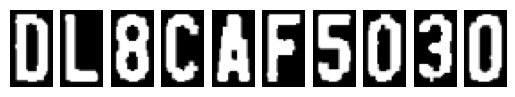

In [37]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [38]:
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char):
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = np.argmax(model.predict(img), axis=-1)[0]
        character = dic[y_] #
        output.append(character)

    plate_number = ''.join(output)

    return plate_number

print(show_results())

1/1 [==============================] - 0s 107ms/step
DL8CAF5030


1/1 [==============================] - 0s 69ms/step


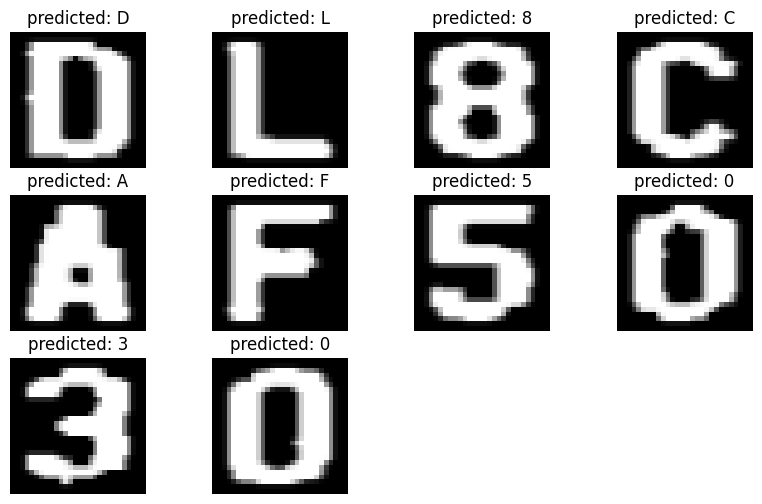

In [39]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()